# STA314 Tutorial 01 — Coding Exercise (Credit data only)

This notebook mirrors the tutorial slides on the `Credit` dataset from the `ISLP` package.

**Goals:**
- Fit and interpret simple and multiple linear regression models
- Read `summary` from model output
- Predict using the fitted model
- Handle qualitative predictors (dummy variables)
- Add and interpret interaction terms

---

## 0. Importing Necessary Packages

In [10]:
# pip install ... in your terminal if any package is missing

import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import statsmodels.api as sm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize , poly)

## 1. Load the Credit dataset

We'll use:
- **Response**: `Balance`
- Predictors: `Income`, `Rating`, `Student`, `Gender`, `Ethnicity`, etc.

(You can inspect the column names below.)

In [11]:
Credit = load_data('Credit')
Credit.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [14]:
Credit.columns

# People could use 'Credit?' to inspect more info on the dataset
# Credit?

Index(['ID', 'Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education',
       'Gender', 'Student', 'Married', 'Ethnicity', 'Balance'],
      dtype='object')

## 2. Simple Linear Regression

We start with a simple model:
$$
\text{Balance} = \beta_0 + \beta_1\,\text{Income} + \epsilon.
$$

Interpretation reminder:
- The **slope** $\hat\beta_1$ is the estimated change in `Balance` for a 1-unit increase in `Income`.
- The **p-value** for `Income` tests $H_0:\beta_1=0$ vs $H_1:\beta_1\neq 0$.

In [20]:
# Specify the Response variable - Income
y = Credit['Balance']

# By hand: build the model matrix X = [1, Income]
X_hand = pd.DataFrame({
    'intercept': np.ones(Credit.shape[0]),
    'Income': Credit['Income']
})

# Peek at the first few rows and confirm
X_hand.head()

,intercept,Income
0,1.0,14.891
1,1.0,106.025
2,1.0,104.593
3,1.0,148.924
4,1.0,55.882


In [21]:
# Fit OLS
model_hand = sm.OLS(y, X_hand)
res_slr_hand = model_hand.fit()

summarize(res_slr_hand)

,coef,std err,t,P>|t|
intercept,246.5148,33.199,7.425,0.0
Income,6.0484,0.579,10.440,0.0


Alternatively, people could use built-in functions `fit` and `transform` to fit the model  and transform X, or use the function `fit_transform` directly:

In [22]:
y = Credit['Balance']
X = MS(['Income']).fit_transform(Credit)
model = sm.OLS(y, X)
res_slr = model.fit()
summarize(res_slr)

,coef,std err,t,P>|t|
intercept,246.5148,33.199,7.425,0.0
Income,6.0484,0.579,10.440,0.0


note that the `summarize` function shows a quick summary of information using built-in function from ISLP package, for a more detailed summary, people could use `summary()` function in python:

In [25]:
res_slr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     109.0
Date:                Thu, 08 Jan 2026   Prob (F-statistic):           1.03e-22
Time:                        11:34:48   Log-Likelihood:                -2970.9
No. Observations:                 400   AIC:                             5946.
Df Residuals:                     398   BIC:                             5954.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    246.5148     33.199      7.425      0.000     181.247     311.783
Income         6.0484      0.579     10.440      0.000       4.909       7.187
==============================================================================
Omnibus:                       42.505   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.975
Skew:                           0.384   Prob(JB):                     2.79e-05
Kurtosis:                       2.182   Cond. No.                         93.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The fitted coefficients can also be retrieved as the `params` attribute of
results:

In [26]:
res_slr.params

intercept    246.514751
Income         6.048363
dtype: float64

### 2.1 Plot the fitted line

We will now plot `Balance` and `Income` using `DataFrame.plot.scatter()`, and  then add the regression line to the resulting plot

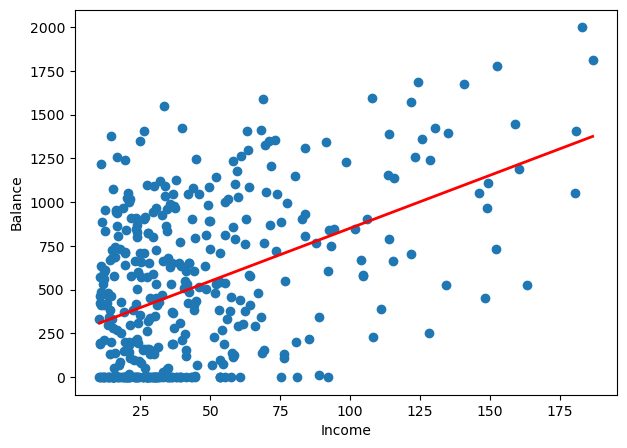

In [46]:
ax = subplots(figsize=(7,5))[1]
ax.scatter(Credit['Income'], Credit['Balance'])
ax.set_xlabel('Income')
ax.set_ylabel('Balance')

# Add fitted line
b0, b1 = res_slr.params['intercept'], res_slr.params['Income']
xgrid = np.linspace(Credit['Income'].min(), Credit['Income'].max(), 200)
ax.plot(xgrid, b0 + b1*xgrid, color='red', linewidth=2)
plt.show()

### 2.2 Quick residual check

We could also perform some diagnosis on the fitted model by plotting the residuals:

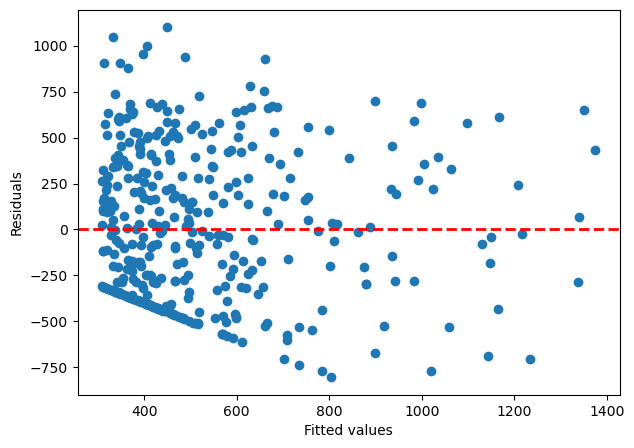

In [34]:
ax = subplots(figsize=(7,5))[1]
ax.scatter(res_slr.fittedvalues, res_slr.resid)
ax.axhline(0, c ='red', ls='--', color='red', linewidth = 2)
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
plt.show()

On the basis of the residual plot, there is some evidence of non-linearity since the residuals don't look purely random.

## 3. Predictions (and intervals)

The `get_prediction()` method can be used to obtain predictions, and produce confidence intervals and prediction intervals for the prediction of medv for given values of lstat.

We first create a new data frame, in this case containing only the variable
`Income`, with the values for this variable at which we wish to make
predictions. We then use the `transform()` method of design to create the
corresponding model matrix.

In [40]:
# for example for 3 values of Income = 20, 40, 80
new_df = pd.DataFrame({'Income':[20, 40, 80]})
design = MS(['Income']).fit(Credit)
new_X = design.transform(new_df)

new_X

,intercept,Income
0,1.0,20
1,1.0,40
2,1.0,80


Next we compute the predictions at `newX`, and view them by extracting
the predicted_mean attribute.

In [43]:
pred = res_slr.get_prediction(new_X)

# Just running pred will not get you the predicted value!
# pred

pred.predicted_mean

array([367.48201876, 488.44928693, 730.38382327])

We can produce confidence intervals for the predicted values.

In [44]:
pred.conf_int(alpha=0.05)

array([[318.16261495, 416.80142257],
       [447.91910797, 528.9794659 ],
       [674.02177937, 786.74586717]])

Prediction intervals are computing by setting `obs=True`:

In [45]:
pred.conf_int(obs=True , alpha=0.05)

array([[-435.87183043, 1170.83586795],
       [-314.41290474, 1291.31147861],
       [ -73.43312318, 1534.20076973]])

For instance, the 95% confidence interval associated with an Income value of
20 is (318.16, 416.80), and the 95% prediction interval is (-435.87, 1170.84). As
expected, the confidence and prediction intervals are centered around the
same point (a predicted value of 367.48 for Balance when Income equals 20), but
the latter are substantially wider.

## 4. Multiple Linear Regression

We will try to include multiple predictors. Let's start with:

$
\text{Balance} = \beta_0 + \beta_1\,\text{Income} + \beta_2\,\text{Gender} + \epsilon.
$

This helps illustrate:
- How coefficients change after adjusting for other variables
- How a qualitative predictor like `Gender` is encoded (dummy variable)

In [48]:
y = Credit['Balance']
X = MS(['Income', 'Gender']).fit_transform(Credit)  # includes intercept automatically
model = sm.OLS(y, X)
res_mlr = model.fit()
summarize(res_mlr)

,coef,std err,t,P>|t|
intercept,233.7663,39.532,5.913,0.000
Income,6.0521,0.580,10.437,0.000
Gender[Female],24.3108,40.847,0.595,0.552


- $\beta_1$ is the change in predicted Balance for a one-unit increase in Income, holding Gender fixed.
- The dummy coefficient (e.g., Gender[Female]) compares Female to the baseline group (e.g., Male), holding Income fixed.

### 4.1 Add in interaction terms to the equation

Now allow the effect of `Income` to differ for male vs female:

$
\text{Balance} = \beta_0 + \beta_1\,\text{Income} + \beta_2\,\text{Gender} + \beta_3\,(\text{Income}\times\text{Gender}) + \epsilon.
$


In [49]:
X = MS(['Income', 'Gender', ('Income','Gender')]).fit_transform(Credit)
res_int = sm.OLS(y, X).fit()
summarize(res_int)

,coef,std err,t,P>|t|
intercept,227.7682,47.857,4.759,0.000
Income,6.1836,0.828,7.472,0.000
Gender[Female],36.0236,66.574,0.541,0.589
Income:Gender,-0.2589,1.161,-0.223,0.824


**Quick interpretation (Income × Gender model):**
- The fitted line for **males** is  
  $\widehat{\text{Balance}} = 227.77 + 6.18\cdot \text{Income}$  (both intercept and Income slope are significant).
- `Gender[Female]` (p = 0.589): no evidence that females have a different **intercept** than males *when Income = 0*.
- `Income:Gender` (p = 0.824): no evidence that the **Income slope** differs between females and males.
- So, based on this model result, a simpler model **without the interaction** (and possibly without Gender) would likely be sufficient.

### 4.2 Qualtitative Predictors with More than two Levels

- `Ethnicity` has multiple levels. When we use `fit_transform`, it automatically creates the required dummy-variable columns.
- There will be one fewer dummy variables than the number of levels.
- The omitted level is the **baseline** (it corresponds to all dummy variables being 0).

In [50]:
X = MS(['Income', 'Rating', 'Ethnicity']).fit_transform(Credit)
X

,intercept,Income,Rating,Ethnicity[Asian],Ethnicity[Caucasian]
0,1.0,14.891,283,0.0,1.0
1,1.0,106.025,483,1.0,0.0
2,1.0,104.593,514,1.0,0.0
3,1.0,148.924,681,1.0,0.0
4,1.0,55.882,357,0.0,1.0
...,...,...,...,...,...
395,1.0,12.096,307,0.0,1.0
396,1.0,13.364,296,0.0,0.0
397,1.0,57.872,321,0.0,1.0
398,1.0,37.728,192,0.0,1.0


In [51]:
res_eth = sm.OLS(y, X).fit()
summarize(res_eth)

,coef,std err,t,P>|t|
intercept,-546.3018,26.175,-20.871,0.000
Income,-7.6814,0.378,-20.300,0.000
Rating,3.9542,0.086,45.867,0.000
Ethnicity[Asian],32.1310,22.988,1.398,0.163
Ethnicity[Caucasian],3.9390,20.033,0.197,0.844


---

## 5. Exercise 

**(5-8 minutes, if no time can skip but make sure people practice at home!)**

Work in **pairs**. Try to complete **at least one** of the following.

**A. Interpretation**
1) Fit `Balance ~ Income + Rating + Student`.
2) Interpret the `Student[...]` coefficient in one sentence.
3) Is it statistically significant at 5%?

**B. Interaction**
1) Fit `Balance ~ Income * Student` (i.e., include the interaction).
2) What is the slope of `Income` for students vs non-students?

**C. Prediction**
Predict Balance (with a 95% CI) for:
- Person 1: Income = 40, Rating = 300, Student = No
- Person 2: Income = 40, Rating = 300, Student = Yes

*(If you need a reminder on `std.error` and `t`-statistics, see Appendix 1 in the slides.)*

In [3]:
# A. Fit the multiple regression

In [2]:
# B. Add interaction


In [1]:
# C. Prediction template
